<a href="https://colab.research.google.com/github/MustafaSincer/kodluyoruzilkrepo/blob/main/Flo_customer_segmentation_with_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
#İmport İşlemleri
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import datetime as dt


In [104]:
#İlgili düzenlemeler
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [136]:
df_ = pd.read_csv("/content/flo_data_20k.csv")
df = df_.copy()

In [19]:
def check_df(dataframe):
    print(dataframe.info())
    print("###########################")
    print(dataframe.describe().T)
    print("#############################")
    print(dataframe.shape)
    print("#############################")
    print(dataframe.head())
check_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [157]:
#Adım 2: Müşterileri segmentlerken kullanacağınız değişkenleri seçiniz.
#Not: Tenure (Müşterinin yaşı), Recency (en son kaç gün önce alışveriş yaptığı) gibi yeni değişkenler oluşturabilirsiniz.
today_date = dt.datetime(2021,6,2)
df["monetary"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df["frequıency"] = df["order_num_total_ever_online"]  + df["order_num_total_ever_offline"]
df["last_order_date"] = df["last_order_date"].apply(pd.to_datetime)
df["first_order_date"] = df["first_order_date"].apply(pd.to_datetime)
df["last_order_date_online"] = df["last_order_date_online"].apply(pd.to_datetime)
df["last_order_date_offline"] = df["last_order_date_offline"].apply(pd.to_datetime)

df["recency"] =df["last_order_date"] - df["first_order_date"]

df["tenure"] = today_date -  df["last_order_date"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   master_id                          19945 non-null  object         
 1   order_channel                      19945 non-null  object         
 2   last_order_channel                 19945 non-null  object         
 3   first_order_date                   19945 non-null  datetime64[ns] 
 4   last_order_date                    19945 non-null  datetime64[ns] 
 5   last_order_date_online             19945 non-null  datetime64[ns] 
 6   last_order_date_offline            19945 non-null  datetime64[ns] 
 7   order_num_total_ever_online        19945 non-null  float64        
 8   order_num_total_ever_offline       19945 non-null  float64        
 9   customer_value_total_ever_offline  19945 non-null  float64        
 10  customer_value_total_e

In [158]:
df["tenure"] = df["tenure"] / pd.Timedelta(hours = 1)
df["recency"] = df["recency"] // pd.Timedelta(hours = 1)

df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,monetary,frequıency,recency,tenure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],939.370,5.000,2856,2304.000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.550,21.000,35256,2544.000
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",585.320,5.000,8784,4488.000
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",121.970,2.000,264,3264.000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],209.980,2.000,13968,2088.000


In [159]:
#Görev 2: K-Means ile Müşteri Segmentasyonu
#Adım 1: Değişkenleri standartlaştırınız



date_list = ['first_order_date','last_order_date','last_order_date_online', 'last_order_date_offline']
num_cols = [col for col in df.columns if df[col].dtypes not in ["O"," datetime64"] ]
num_cols
df[num_cols].head()

df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,monetary,frequıency,recency,tenure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],939.370,5.000,2856,2304.000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.550,21.000,35256,2544.000
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",585.320,5.000,8784,4488.000
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",121.970,2.000,264,3264.000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],209.980,2.000,13968,2088.000


In [160]:
df_new = df[num_cols]
df_new.head()

,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,monetary,frequıency,recency,tenure
0,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,939.370,5.000,2856,2304.000
1,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,2013.550,21.000,35256,2544.000
2,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,585.320,5.000,8784,4488.000
3,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,121.970,2.000,264,3264.000
4,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,209.980,2.000,13968,2088.000


In [161]:
date_list = ['first_order_date','last_order_date','last_order_date_online', 'last_order_date_offline']
df_new_one = df_new.drop(date_list,axis = 1 )
df_new_one.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,monetary,frequıency,recency,tenure
0,4.000,1.000,139.990,799.380,939.370,5.000,2856,2304.000
1,19.000,2.000,159.970,1853.580,2013.550,21.000,35256,2544.000
2,3.000,2.000,189.970,395.350,585.320,5.000,8784,4488.000
3,1.000,1.000,39.990,81.980,121.970,2.000,264,3264.000
4,1.000,1.000,49.990,159.990,209.980,2.000,13968,2088.000


In [163]:

sc = MinMaxScaler((0, 1))

df_new_scale = sc.fit_transform(df_new_one)

df_new_scale[0:5]

array([[0.01507538, 0.        , 0.00717814, 0.01739526, 0.01950257,
        0.015     , 0.03922215, 0.25479452],
       [0.09045226, 0.00925926, 0.00828145, 0.04071459, 0.04292553,
        0.095     , 0.4841793 , 0.28219178],
       [0.01005025, 0.00925926, 0.00993808, 0.00845796, 0.01178235,
        0.015     , 0.12063283, 0.50410959],
       [0.        , 0.        , 0.00165607, 0.00152609, 0.0016788 ,
        0.        , 0.00362558, 0.36438356],
       [0.        , 0.        , 0.00220828, 0.0032517 , 0.0035979 ,
        0.        , 0.19182597, 0.23013699]])

In [164]:
#Adım 2: Optimum küme sayısını belirleyiniz.

kmeans = KMeans( random_state=45).fit(df_new_scale)
kmeans.inertia_
# 8 tane kümelemede  SSE = 276.1015796236985

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


276.1015796236985

In [165]:
K = range(1,15)
sse = []

for k in range(1,15):
    kmeans = KMeans(n_clusters=k).fit(df_new_scale)
    sse.append(kmeans.inertia_)
sse

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[2234.900741422851,
 1046.738096431769,
 739.4388617369116,
 515.5394285261355,
 410.1929766066262,
 337.7783562284136,
 302.9922051212716,
 276.10066033769476,
 251.50040172115314,
 229.87318878122417,
 211.6251010762005,
 195.66793773276888,
 183.23293959993498,
 173.17981251138028]

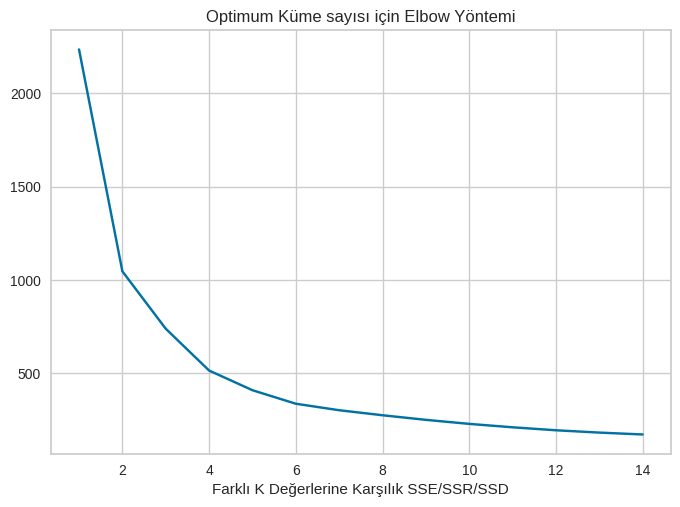

In [166]:
plt.plot(K, sse, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme sayısı için Elbow Yöntemi")
plt.show(block = True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

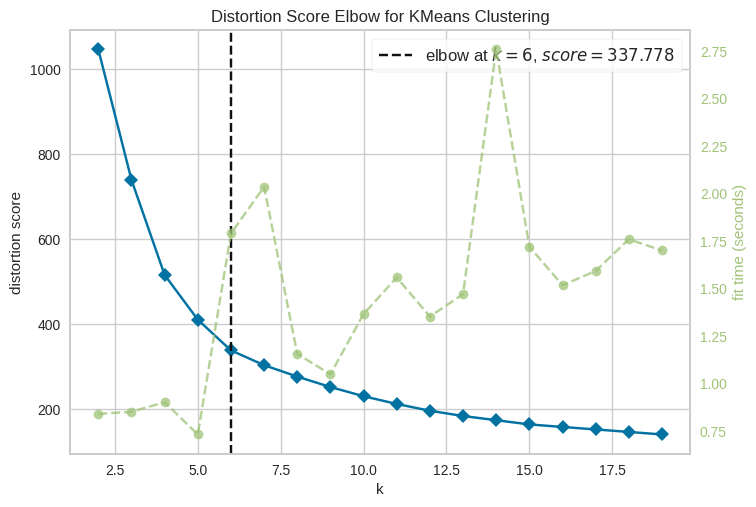

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [167]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_new_scale)
elbow.show(block = True)
# optimum küme sayısını 6 buldu

In [168]:
#Final kümeleme

kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df_new_scale)
kmeans.inertia_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


337.7785737868051

In [169]:
cluster_k_means = kmeans.labels_
cluster_k_means

array([3, 4, 0, ..., 1, 3, 5], dtype=int32)

In [170]:
df_new["Cluster"] = cluster_k_means
df_new.head()

<ipython-input-170-c69e0c9eaed8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Cluster"] = cluster_k_means


,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,monetary,frequıency,recency,tenure,Cluster
0,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,939.370,5.000,2856,2304.000,3
1,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,2013.550,21.000,35256,2544.000,4
2,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,585.320,5.000,8784,4488.000,0
3,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,121.970,2.000,264,3264.000,3
4,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,209.980,2.000,13968,2088.000,3


In [171]:
df_new["Cluster"] = df_new["Cluster"] + 1
df_new.head()

<ipython-input-171-45129cf0ed07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Cluster"] = df_new["Cluster"] + 1


,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,monetary,frequıency,recency,tenure,Cluster
0,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,939.370,5.000,2856,2304.000,4
1,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,2013.550,21.000,35256,2544.000,5
2,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,585.320,5.000,8784,4488.000,1
3,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,121.970,2.000,264,3264.000,4
4,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,209.980,2.000,13968,2088.000,4


In [173]:
df_new.groupby("Cluster").agg({"monetary" : ["count","mean","median"],"frequıency" : ["count","mean","median"] ,"recency" : ["count","mean","median"], "tenure" : ["count","mean","median"]})


monetary                  frequıency              recency                     tenure                  
           count     mean  median      count  mean median   count      mean    median  count     mean   median
Cluster                                                                                                       
1           3892  620.771 482.425       3892 4.088  3.000    3892 10965.046 10344.000   3892 4873.233 4776.000
2           6155  807.661 600.970       6155 4.990  4.000    6155 13415.719 13680.000   6155  767.017  696.000
3            993  898.586 664.950        993 7.125  5.000     993 41461.003 40488.000    993 6243.843 6120.000
4           4705  656.822 503.450       4705 4.393  4.000    4705 12030.198 11976.000   4705 2674.921 2640.000
5           1666 1335.236 914.185       1666 9.741  7.000    1666 43669.887 41796.000   1666 1713.191 1656.000
6           2534  548.235 442.310       2534 3.798  3.000    2534  9245.664  7872.000   2534 7700.780 7800.000

In [ ]:
#Görev  3
